In [25]:
import numpy as np
import quaternion as qt
import library.ulogReader as ur
import library.quaternionUtils as qu
import library.choleskyDecomposition as cd
import library.quaternionVisualization as qv

from pyulog import ULog

## Wczytanie danych lotu drona

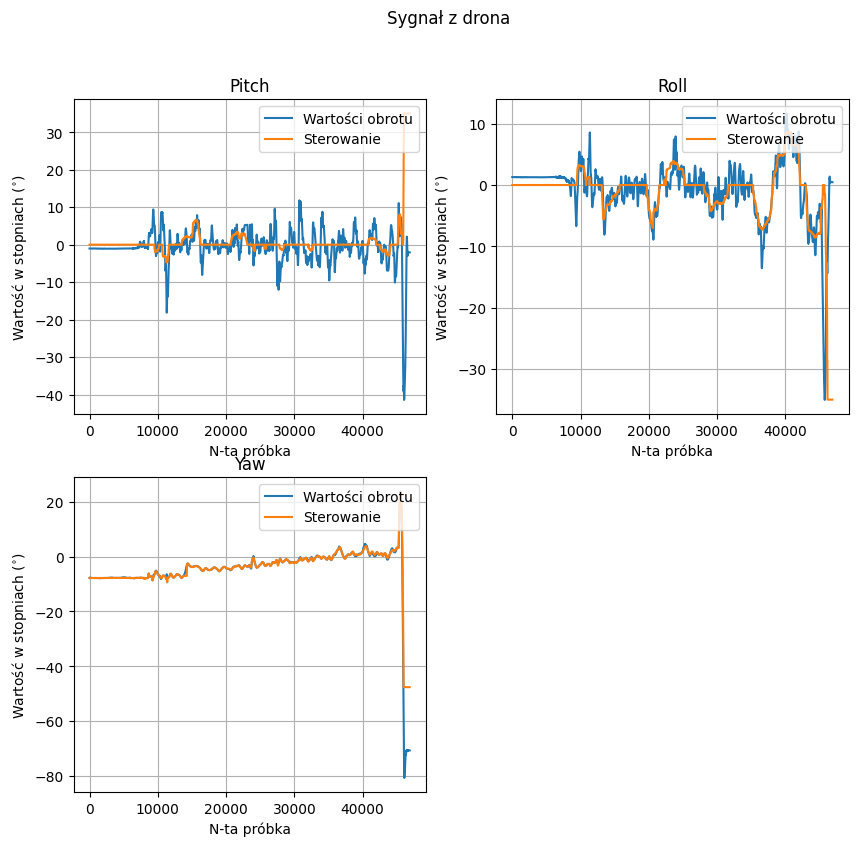

In [26]:
ulog_path = './ulogs/639_bs10_out_alt.ulg'
ulog = ULog(ulog_path)

attitude, attitude_time   = ur.readAttitude(ulog)
navigator, navigator_time = ur.readNavigator(ulog)

min_value = min(attitude_time[0], navigator_time[0])
navigator_time = (navigator_time - min_value) /1e3
attitude_time  = (attitude_time - min_value) / 1e3

qv.display_quat_as_euler([attitude, navigator], [attitude_time,navigator_time], ['Wartości obrotu', 'Sterowanie'], title='Sygnał z drona')


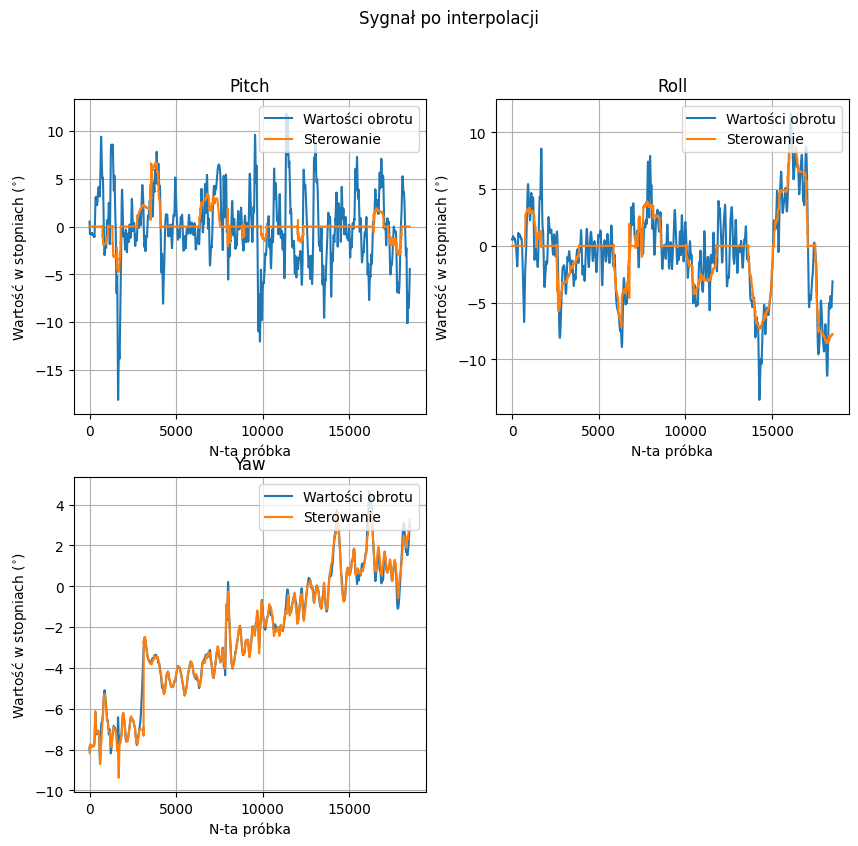

In [27]:
start_time = 8e3   
end_time   = 45e3

# Config interpolation
dt = 2      # Delta time in ms
degree = 3  # Spline degree

# Post resampling time
it_t = np.arange(start_time, end_time, dt)
attitude  = qu.splineInterpolation(attitude, attitude_time, it_t, degree)
navigator = qu.splineInterpolation(navigator, navigator_time, it_t, degree)
attitude_time  = it_t
navigator_time = it_t

qv.display_quat_as_euler([attitude, navigator], [range(attitude.shape[0]),range(navigator.shape[0])], ['Wartości obrotu', 'Sterowanie'], title='Sygnał po interpolacji')

### Metoda Yule-Walkera
---  

In [28]:
P_ORDER    = 5
DOWN_SAMPLING = 5
K_FORECAST = [1,3,7]
N_WINDOW = 8           # Minimal value (N_WINDOW > P_ORDER + 1)
START_WINDOW = 30
MU = 5e-3

x = np.copy(attitude)[::DOWN_SAMPLING]
y = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

corr_matrix = qu.correlationMatrix(x[:START_WINDOW][::-1], P_ORDER + 1 , normalize=True)

for i in range(START_WINDOW, x.shape[0]+1):
    tmp_corr_matrix = qu.correlationMatrix(x[i-N_WINDOW : i][::-1], P_ORDER + 1, normalize=True)
    corr_matrix = (1-MU) * corr_matrix + MU * tmp_corr_matrix
    tmp_corr_matrix = np.copy(corr_matrix)
    np.fill_diagonal(tmp_corr_matrix, tmp_corr_matrix.diagonal()+qt.quaternion(1e-6,0,0,0))
    l = cd.choleskyDecomposition(tmp_corr_matrix[:-1, :-1])
    w = cd.solveLLHEquation(l, tmp_corr_matrix[1:,0])

    for k, k_steps in enumerate(K_FORECAST):
        y[k, i + k_steps - 1] = qu.predictionKSteps(np.copy(x[i-P_ORDER : i][::-1]), w, k_steps)

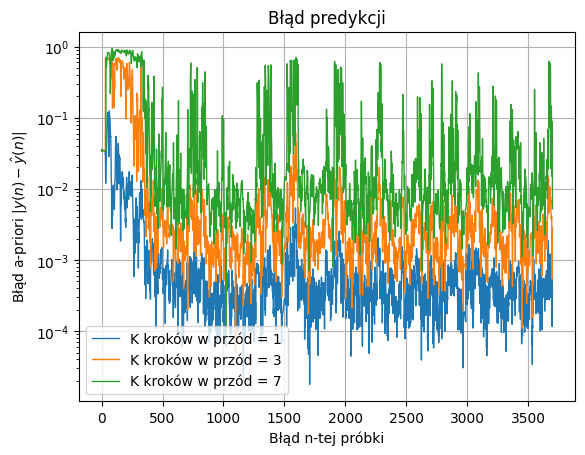

In [29]:
qv.displayPredictionError(x,y,K_FORECAST, label_form='K kroków w przód = {}')

### Zestawienie błędu predykcji wraz ze zmianą sygnału sterującego 

In [30]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [53]:
navigator_euler = qu.quaternionToEuler(navigator, degrees = False)[::DOWN_SAMPLING]
diff_navigator = np.sum(np.sqrt((navigator_euler[1:] - navigator_euler[:-1])**2), axis = 1)

er_priori = qu.quaternionError(y[1,  : x.shape[0]], x)

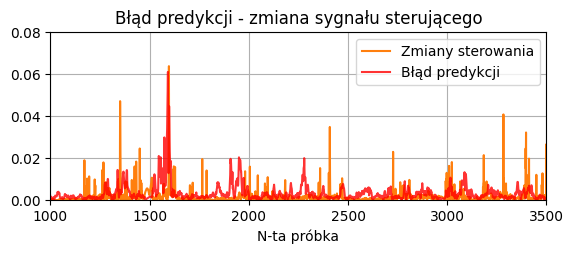

In [101]:
import matplotlib.pyplot as plt
plt.subplot(2,1,1)
plt.plot(diff_navigator, 'C1', label='Zmiany sterowania')
plt.plot(er_priori, 'r', alpha=0.8, label='Błąd predykcji')
plt.title('Błąd predykcji - zmiana sygnału sterującego')
plt.ylim([0.0, 0.08])
plt.xlim([1000, 3500])
plt.xlabel('N-ta próbka')
plt.legend()
plt.grid()